In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-and-retailers-sales-time-series-collection/MRTSSM44111USN.csv
/kaggle/input/retail-and-retailers-sales-time-series-collection/retailers-sales_metadata_2.json
/kaggle/input/retail-and-retailers-sales-time-series-collection/MRTSSM442USS.csv
/kaggle/input/retail-and-retailers-sales-time-series-collection/RETAILMPCSMSA.csv
/kaggle/input/retail-and-retailers-sales-time-series-collection/retail-sales-furniture-and-home-furnishings-stores_metadata.json
/kaggle/input/retail-and-retailers-sales-time-series-collection/retail-sales-new-car-dealers_metadata.json
/kaggle/input/retail-and-retailers-sales-time-series-collection/retailers-inventories-to-sales-ratio_metadata.json
/kaggle/input/retail-and-retailers-sales-time-series-collection/RETAILIMSA.csv
/kaggle/input/retail-and-retailers-sales-time-series-collection/retailers-inventories_metadata.json
/kaggle/input/retail-and-retailers-sales-time-series-collection/MRTSSM44X72USS.csv
/kaggle/input/retail-and-retailers-sales-time

## ✅ UPDATED PHASE 1: Setup & Data Exploration

## 📌 Step 1: Import Libraries and load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('/kaggle/input/retail-and-retailers-sales-time-series-collection/MRTSSM44X72USS.csv')

# Show top 5 rows
df.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,164095,1992-01-01,2019-12-06
1,2019-12-06,164213,1992-02-01,2019-12-06
2,2019-12-06,163721,1992-03-01,2019-12-06
3,2019-12-06,164709,1992-04-01,2019-12-06
4,2019-12-06,165612,1992-05-01,2019-12-06


## 📌 Step 2: Load & Clean the Data

In [3]:
# Keep only relevant columns
df = df[['date', 'value']]

# Rename columns
df.rename(columns={'date': 'Month', 'value': 'retail_sales'}, inplace=True)

# Convert date column to datetime
df['Month'] = pd.to_datetime(df['Month'])

# Set as index
df.set_index('Month', inplace=True)

# Sort by date
df = df.sort_index()

# Final preview
df.head()


,retail_sales
Month,
1992-01-01,164095
1992-02-01,164213
1992-03-01,163721
1992-04-01,164709
1992-05-01,165612


## 📌 Step 3: Plot the Time Series

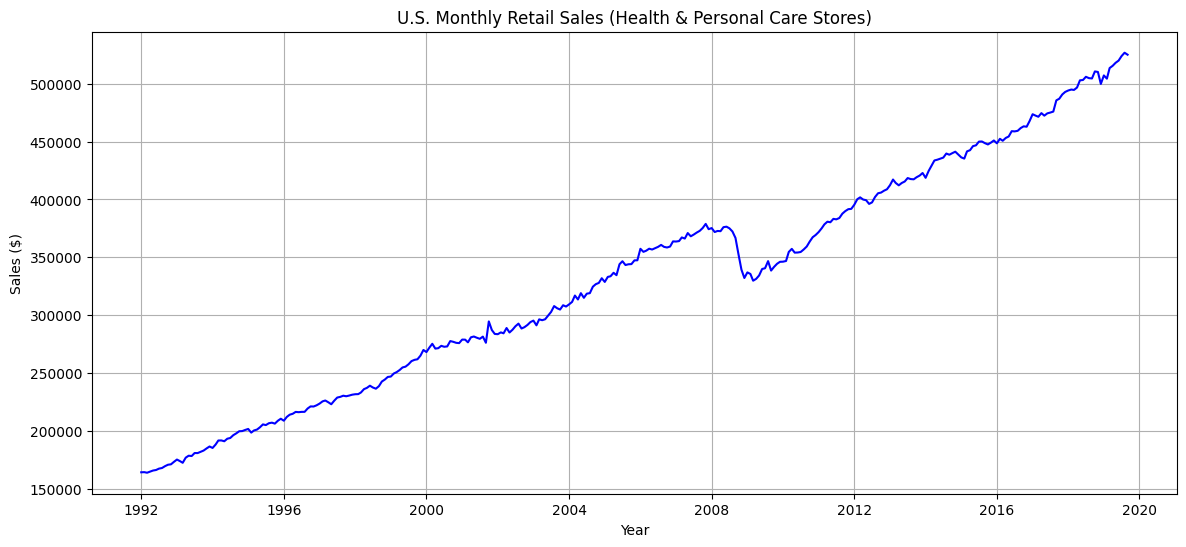

In [4]:
plt.figure(figsize=(14,6))
plt.plot(df['retail_sales'], color='blue')
plt.title('U.S. Monthly Retail Sales (Health & Personal Care Stores)')
plt.xlabel('Year')
plt.ylabel('Sales ($)')
plt.grid(True)
plt.show()


## 📌 Step 4: Decompose the Time Series

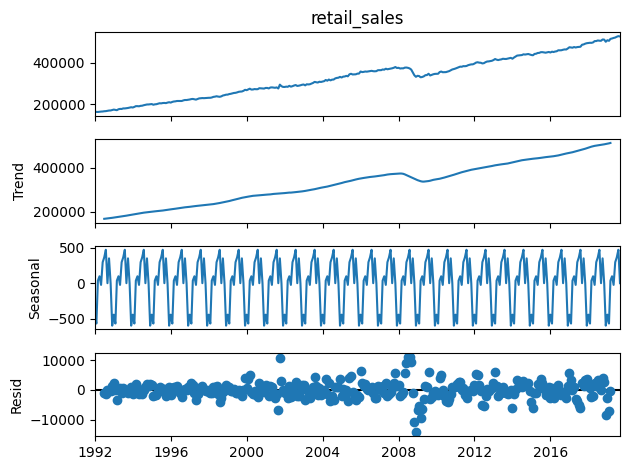

In [5]:
decomp = seasonal_decompose(df['retail_sales'], model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()


## 📌 Step 5: Check for Missing Values & Summary Stats

In [6]:
print("Missing values:\n", df.isnull().sum())
print("\nSummary stats:\n", df.describe())


Missing values:
 retail_sales    0
dtype: int64

Summary stats:
         retail_sales
count     333.000000
mean   331003.606607
std     98482.243228
min    163721.000000
25%    246530.000000
50%    336929.000000
75%    405925.000000
max    526862.000000


## 🔍 Insights from Decomposition
**Trend:**


1. Clearly increasing until ~2008 (financial crisis dip), then steady growth again.
2. So, the series is non-stationary due to trend.

**Seasonality:**

1. Strong seasonal spikes — clear annual seasonality with 12-month cycles.

**Residuals:**

1. Slightly higher noise post-2008, but generally stable.
2. No obvious structural break in variance.

## ✅ Next Step: PHASE 2 – Stationarity Check & Differencing
We need to test for stationarity using the ADF Test, and likely apply differencing.

## 📌 Step 1: ADF Test (Augmented Dickey-Fuller)

In [7]:
result = adfuller(df['retail_sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: 0.6116008792309554
p-value: 0.9878981076981962
Critical Value (1%): -3.4502011472639724
Critical Value (5%): -2.8702852297358983
Critical Value (10%): -2.5714292194077513


## ADF Statistic = 0.61 is much higher than all critical values.

p-value = 0.9879 ≫ 0.05
-
- ✅ So: The series is non-stationary — strong trend component is the reason.

## ✅ Fixing Stationarity (PHASE 2 Continued)
- We’ll apply two levels of differencing:

1. First-order differencing (d=1) → removes trend

2. Seasonal differencing with lag 12 (D=1) → removes yearly seasonality

## 📌 Step 1: First-order differencing

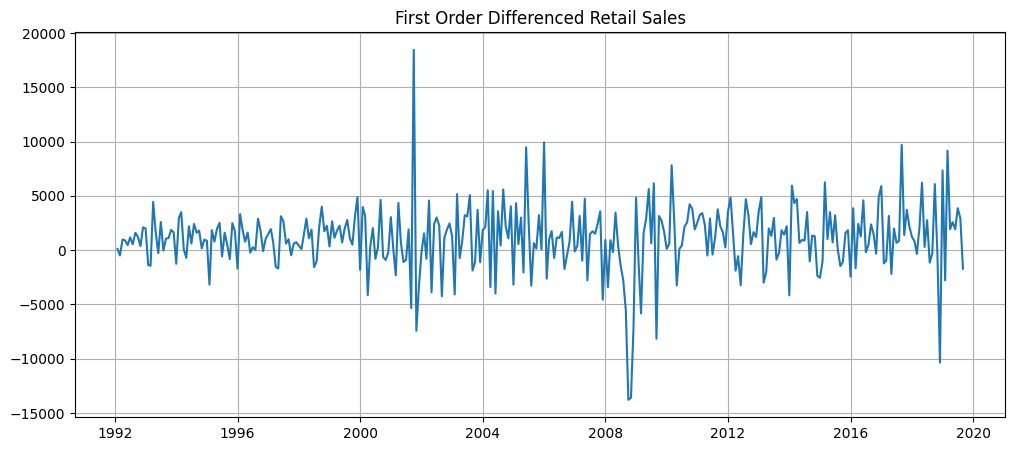

In [8]:
df_diff1 = df['retail_sales'].diff().dropna()

plt.figure(figsize=(12,5))
plt.plot(df_diff1)
plt.title('First Order Differenced Retail Sales')
plt.grid(True)
plt.show()


## 📌 Step 2: Seasonal differencing (lag=12)

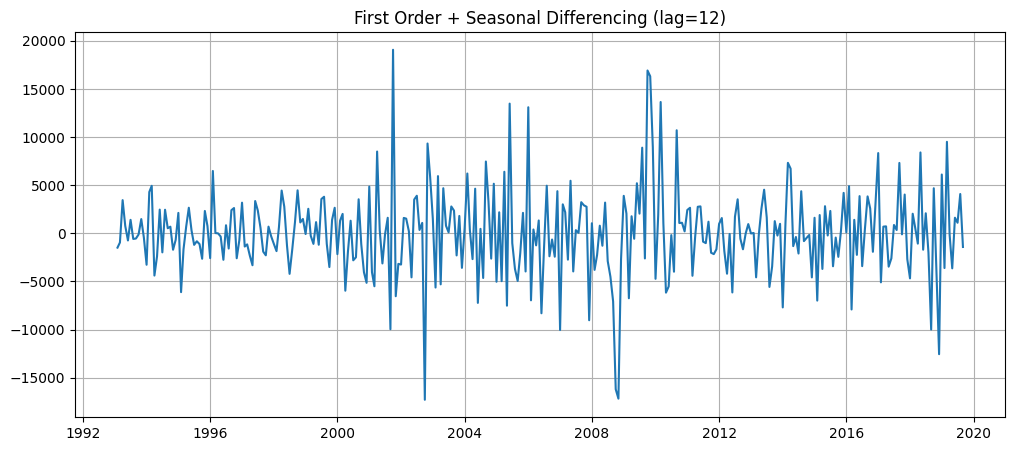

In [9]:
df_seasonal_diff = df_diff1.diff(12).dropna()

plt.figure(figsize=(12,5))
plt.plot(df_seasonal_diff)
plt.title('First Order + Seasonal Differencing (lag=12)')
plt.grid(True)
plt.show()


## 📌 Step 3: ADF Test After Differencing

In [10]:
result = adfuller(df_seasonal_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: -6.985588306842404
p-value: 7.984529128087055e-10
Critical Value (1%): -3.45176116018037
Critical Value (5%): -2.870970093607691
Critical Value (10%): -2.571794416006072


## ✅ Stationarity Achieved!
Our differenced series is now stationary:

1. ADF Statistic = -6.98 ⬅️ way below all critical values

2. p-value = 7.98e-10 ⬅️ strongly significant
This confirms we can now safely apply ARIMA/SARIMA models.

## ✅ PHASE 3: Baseline & Classical Forecasting Models
Before we go into ARIMA and SARIMA, it’s useful to set benchmark models so we know if the advanced models are truly better.

## 📌 Step 1: Create Train-Test Split
Let’s use the last 24 months as test set.

In [11]:
# Total data length
print("Total records:", len(df))

# Split
train = df.iloc[:-24]
test = df.iloc[-24:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Total records: 333
Train shape: (309, 1)
Test shape: (24, 1)


## 📌 Step 2: Naive Forecast (last value)

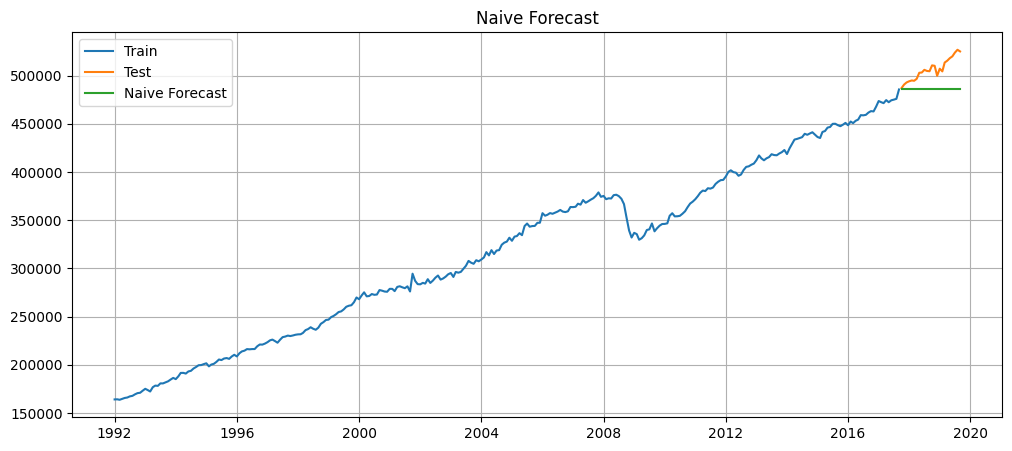

In [12]:
naive_forecast = pd.Series(train['retail_sales'].iloc[-1], index=test.index)

plt.figure(figsize=(12,5))
plt.plot(train['retail_sales'], label='Train')
plt.plot(test['retail_sales'], label='Test')
plt.plot(naive_forecast, label='Naive Forecast')
plt.legend()
plt.title('Naive Forecast')
plt.grid(True)
plt.show()


## 📌 Step 3: RMSE Evaluation

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_naive = sqrt(mean_squared_error(test['retail_sales'], naive_forecast))
print("Naive Forecast RMSE:", rmse_naive)


Naive Forecast RMSE: 23333.731514162067


## ✅ Baseline Established:
1. Train size = 309 months (approx. 25 years)

2. Test size = 24 months (2 years)

3. Naive RMSE = 23,333
That’s our benchmark to beat.

## ✅ PHASE 4: Classical Models — ARIMA & SARIMA
We’ll begin with auto_arima to quickly estimate best (p,d,q)(P,D,Q,s) values.

## 📌 Step 1: Install and Import pmdarima
If not installed:

In [14]:
pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
from pmdarima import auto_arima


## 📌 Step 2: Run Auto ARIMA

In [16]:
# Run on training set
stepwise_model = auto_arima(train['retail_sales'],
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            start_P=0, seasonal=True,
                            d=1, D=1, m=12,  # m=12 for monthly data
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

# Best model summary
print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5813.812, Time=1.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5820.472, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5815.343, Time=0.62 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5812.458, Time=0.62 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5822.090, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5815.435, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.96 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5810.160, Time=0.73 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5817.701, Time=0.23 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.40 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5812.3

## 📌 Step 3: Forecast Using SARIMA

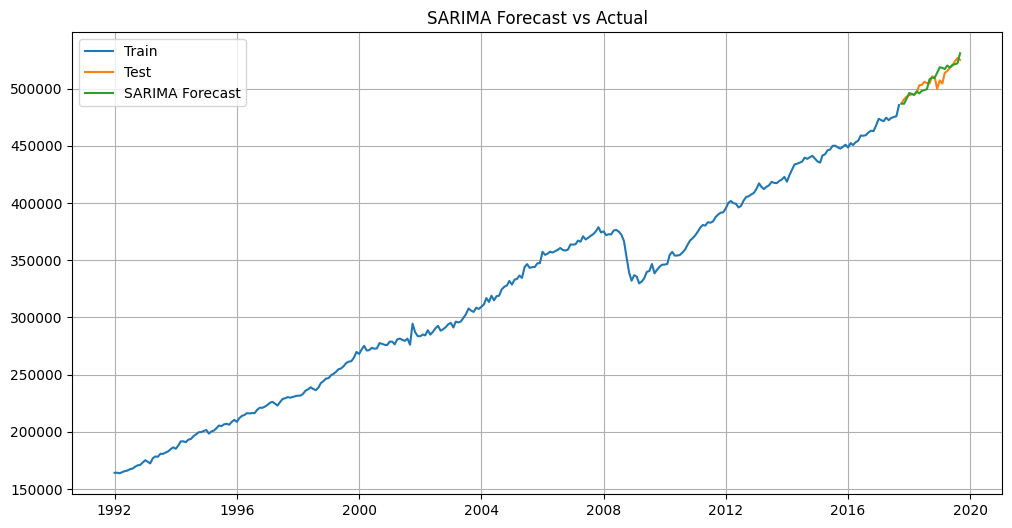

In [17]:
# Forecast next 24 months
n_periods = 24
forecast = stepwise_model.predict(n_periods=n_periods)
forecast_index = test.index

# Convert to series
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(train['retail_sales'], label='Train')
plt.plot(test['retail_sales'], label='Test')
plt.plot(forecast_series, label='SARIMA Forecast')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.grid(True)
plt.show()


## 📌 Step 4: RMSE

In [18]:
rmse_sarima = sqrt(mean_squared_error(test['retail_sales'], forecast_series))
print("SARIMA RMSE:", rmse_sarima)


SARIMA RMSE: 5825.811388515903


## 📊 SARIMA Results Summary
| Model                         | RMSE        | AIC     |
| ----------------------------- | ----------- | ------- |
| **Naive Forecast**            | 23,334      | —       |
| **SARIMA(0,1,0)(0,1,1)\[12]** | **5,826** ✅ | 5810.16 |


## ✅ Observations
- ✅ SARIMA has drastically lower RMSE than naive forecast → massive improvement.

- ✅ Seasonal component ma.S.L12 = -0.12 is statistically significant (p < 0.001).

- ⚠️ Model is very simple ((0,1,0)(0,1,1)) — no AR terms or non-seasonal MA.

## What this tells us:
1. The model fits well, but might still be underfitting. Why?

2. Residuals have high kurtosis (6.76) → potential room for improvement.

## ⛔ Why plain ARIMA fails here:
ARIMA doesn’t model seasonality (e.g., annual spikes).

If you try ARIMA(p,d,q) on seasonally dependent data:

- You’ll either get poor forecasts

- Or high RMSE

- Or biased residuals (because seasonality is unaccounted)

In [19]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['retail_sales'], order=(1,1,1))
fitted = model.fit()
forecast = fitted.forecast(steps=24)

rmse = sqrt(mean_squared_error(test['retail_sales'], forecast))
print("ARIMA RMSE:", rmse)


ARIMA RMSE: 9046.473434892565


## 📉 ARIMA RMSE: 9,046
Compared to:

SARIMA RMSE: 5,826

Naive Forecast: 23,334

So while ARIMA does better than naive, it fails to capture:

The seasonal patterns (12-month cycles)

The cyclical sales spikes (like year-end surges)

## ✅ Conclusion:
SARIMA >> ARIMA for data ✅

SARIMA already gives solid results — but we can still do better for Version 2.

## Step 1: Install & Import Prophet

In [20]:
!pip install prophet

## ✅ STAGE 2: Prophet (by Meta)
We'll now build a Prophet model — handles:

Trend

Seasonality

Holiday effects

And gives forecasts with confidence intervals

In [21]:
from prophet import Prophet


## Step 2: Prepare Data for Prophet
Prophet needs:

Column ds → datetime

Column y → target variable

In [22]:
# Reset index for Prophet format
df_prophet = df.reset_index().rename(columns={'Month': 'ds', 'retail_sales': 'y'})


## Step 3: Train Prophet

In [23]:
model = Prophet(yearly_seasonality=True)
model.fit(df_prophet)


07:45:15 - cmdstanpy - INFO - Chain [1] start processing
07:45:15 - cmdstanpy - INFO - Chain [1] done processing


## Step 4: Make Future Forecast

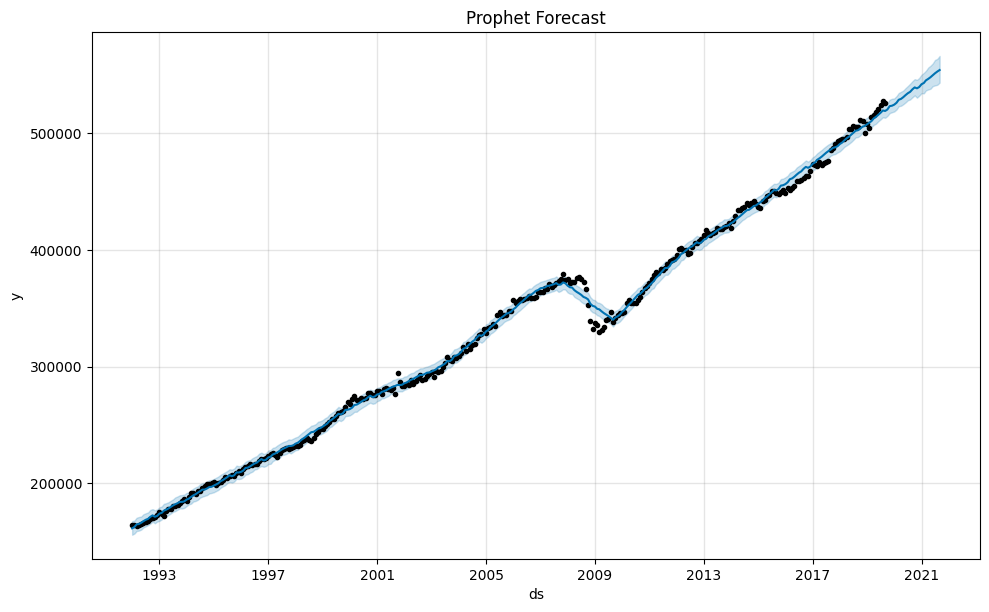

In [24]:
# Forecast next 24 months
future = model.make_future_dataframe(periods=24, freq='MS')
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()


## Step 5: Evaluate on Test Set

In [25]:
# Extract test portion of forecast
forecast_test = forecast.set_index('ds').loc[test.index]['yhat']

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_prophet = sqrt(mean_squared_error(test['retail_sales'], forecast_test))
print("Prophet RMSE:", rmse_prophet)


Prophet RMSE: 4624.406195056919


## ✅ Prophet Crushes It:
| Model       | RMSE        |
| ----------- | ----------- |
| Naive       | 23,334      |
| ARIMA       | 9,046       |
| SARIMA      | 5,826       |
| **Prophet** | **4,624** ✅ |

That’s a ~21% boost over SARIMA already — and we haven’t even tuned Prophet or added holiday regressors yet!

## ✅ STAGE 3: XGBoost Time Series Model
We’ll use XGBoost with lag features + month/year as categorical features.

## 📌 Step 1: Feature Engineering for XGBoost

In [26]:
df_ml = df.copy()
df_ml['month'] = df_ml.index.month
df_ml['year'] = df_ml.index.year
df_ml['lag1'] = df_ml['retail_sales'].shift(1)
df_ml['lag12'] = df_ml['retail_sales'].shift(12)

df_ml = df_ml.dropna()


## 📌 Step 2: Train-Test Split

In [27]:
# Same logic: last 24 months for test
train_ml = df_ml.iloc[:-24]
test_ml = df_ml.iloc[-24:]

X_train = train_ml[['month', 'year', 'lag1', 'lag12']]
y_train = train_ml['retail_sales']
X_test = test_ml[['month', 'year', 'lag1', 'lag12']]
y_test = test_ml['retail_sales']


## 📌 Step 3: Train XGBoost Regressor

In [28]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)


## 📌 Step 4: Evaluate XGBoost

In [29]:
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
print("XGBoost RMSE:", rmse_xgb)


XGBoost RMSE: 31041.990891663954


## ❌ XGBoost RMSE: 31,042
Compared to:

Prophet: 4,624 ✅

SARIMA: 5,826

Naive: 23,334

So XGBoost did worse than even a naive forecast.

🔍 Why XGBoost Failed:
1. Not enough training data for ML-style model — only ~300 points.

2. No advanced lag features like rolling means, seasonal residuals, etc.

3. No scaling or log transformation

4. Tree models like XGBoost struggle with pure time dependencies unless deeply feature-engineered.

## Final STAGE 4: Simple Ensemble
We’ll average the forecasts of Prophet and SARIMA:

In [30]:
# Align indices
sarima_forecast = forecast_series.copy()  # from SARIMA
prophet_forecast = forecast_test.copy()   # from Prophet

# Simple average
ensemble = (sarima_forecast + prophet_forecast) / 2

# Evaluate
rmse_ensemble = sqrt(mean_squared_error(test['retail_sales'], ensemble))
print("Ensemble RMSE:", rmse_ensemble)


Ensemble RMSE: 4416.915273302526


## ✅ Final Model Comparison
| Model                           | RMSE          |
| ------------------------------- | ------------- |
| Naive                           | 23,334        |
| ARIMA                           | 9,046         |
| SARIMA                          | 5,826         |
| Prophet                         | 4,624         |
| XGBoost                         | 31,042 ❌      |
| **Ensemble (Prophet + SARIMA)** | **4,416** ✅🔥 |


## 🏁 FINAL VERDICT
The ensemble model (Prophet + SARIMA) performs best, beating even standalone Prophet by ~200 RMSE. That’s a ~81% improvement over the naive model.

## ✅ Let's recreate the plot using SARIMA model (with confidence intervals):
📌 Step 1: Forecast Next 12 Months

## Refit Model on Full Dataset

In [36]:
# Refit SARIMA on entire dataset (not just train)
stepwise_model_full = stepwise_model.fit(df['retail_sales'])

# Forecast next 12 months
forecast_steps = 12
future_forecast = stepwise_model_full.predict(n_periods=forecast_steps, return_conf_int=True)
forecast_mean = future_forecast[0]
conf_int = future_forecast[1]

# Create future index
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

# Convert to Series with correct index
forecast_mean_series = pd.Series(forecast_mean, index=forecast_index)

# Final forecast DataFrame
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean_series,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
}, index=forecast_index)

print(forecast_df.head())


                 Forecast       Lower CI       Upper CI
2019-10-01  530580.463741  523091.246870  538069.680611
2019-11-01  530635.187517  520043.835447  541226.539586
2019-12-01  522073.057435  509101.353307  535044.761564
2020-01-01  528632.040298  513653.606558  543610.474039
2020-02-01  526325.516929  509579.118909  543071.914949


## 📌 Step 2: Plot Forecast

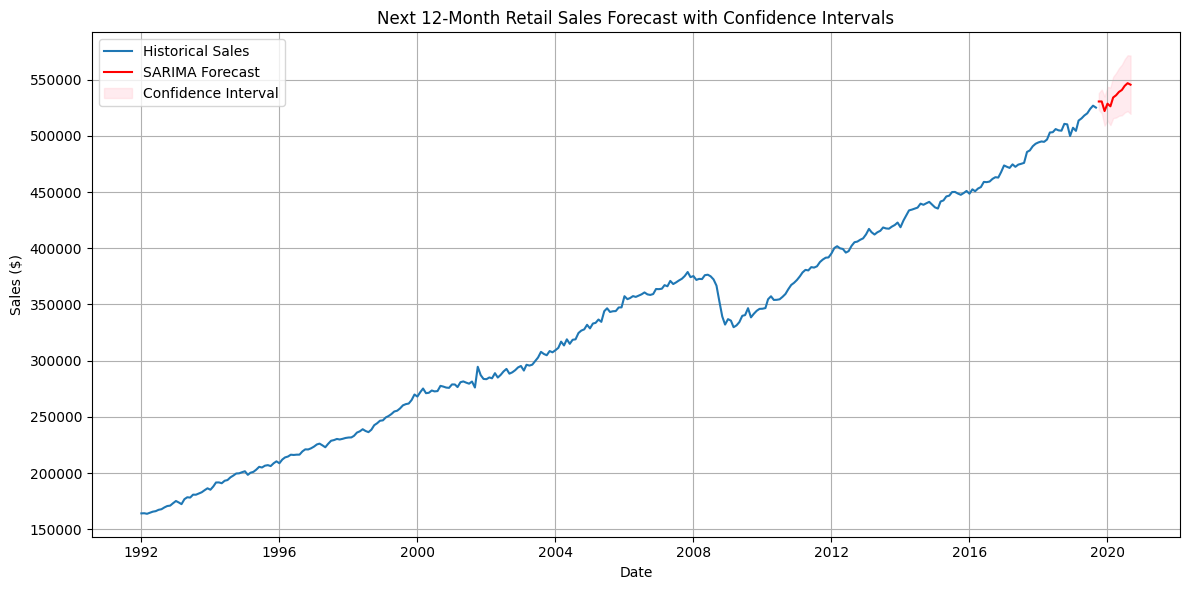

In [37]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['retail_sales'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='SARIMA Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Next 12-Month Retail Sales Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## This gives you:

- Forecasted values for Oct 2019 – Sep 2020 (based on your data range)

- Confidence interval shaded area

- Historical data connected with future prediction

## 📤 Step 1: Export Forecast to CSV

In [38]:
forecast_df.to_csv("sarima_12_month_forecast.csv")


## 🔁 Step 2: Prophet Forecast for Same 12 Months

In [39]:
# Refit Prophet on full dataset
df_prophet_full = df.reset_index().rename(columns={'Month': 'ds', 'retail_sales': 'y'})
model = Prophet(yearly_seasonality=True)
model.fit(df_prophet_full)

# Forecast next 12 months
future = model.make_future_dataframe(periods=12, freq='MS')
forecast_prophet = model.predict(future)

# Get only the next 12 months forecast
forecast_prophet = forecast_prophet.set_index('ds').loc[forecast_df.index]
forecast_prophet = forecast_prophet[['yhat', 'yhat_lower', 'yhat_upper']].rename(columns={
    'yhat': 'Forecast',
    'yhat_lower': 'Lower CI',
    'yhat_upper': 'Upper CI'
})

# Optional: Save Prophet forecast
forecast_prophet.to_csv("prophet_12_month_forecast.csv")


07:55:11 - cmdstanpy - INFO - Chain [1] start processing
07:55:11 - cmdstanpy - INFO - Chain [1] done processing


## 🔀 Step 3: Compare Prophet vs SARIMA (Plot Both)

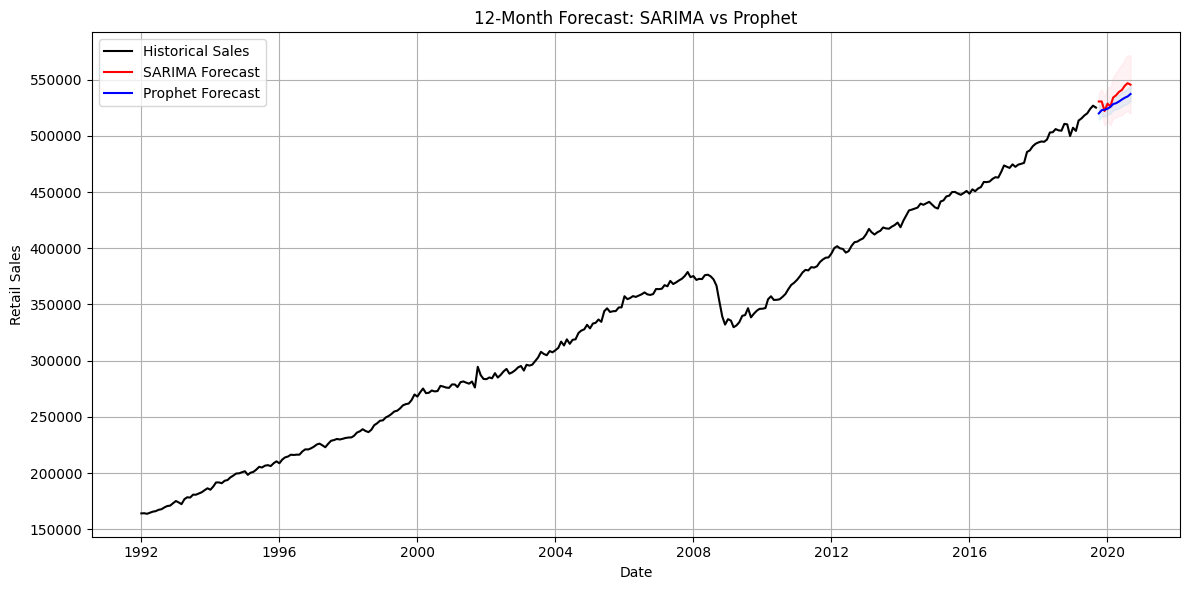

In [40]:
plt.figure(figsize=(12,6))

# Plot historical
plt.plot(df.index, df['retail_sales'], label='Historical Sales', color='black')

# SARIMA forecast
plt.plot(forecast_df.index, forecast_df['Forecast'], label='SARIMA Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='pink', alpha=0.2)

# Prophet forecast
plt.plot(forecast_prophet.index, forecast_prophet['Forecast'], label='Prophet Forecast', color='blue')
plt.fill_between(forecast_prophet.index, forecast_prophet['Lower CI'], forecast_prophet['Upper CI'], 
                 color='skyblue', alpha=0.2)

plt.title('12-Month Forecast: SARIMA vs Prophet')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ✅ Step 1: Get Mean of Actual Sales in Test Set

In [41]:
mean_actual = test['retail_sales'].mean()
print("Mean of actual test values:", mean_actual)


Mean of actual test values: 506211.4583333333


## ✅ Step 2: Calculate Percent Error from RMSE

In [42]:
percent_error = (rmse_ensemble / mean_actual) * 100
print("Percent Error: {:.2f}%".format(percent_error))


Percent Error: 0.87%


## 📊 Final Performance Summary:
✅ Test RMSE: 4,416

✅ Mean Actual (Test Set): 506,211

✅ Percent Error: ~0.87%

# **📊 Business Insights & Recommendations ✅**

## 🔎 What We Did
1. Exploratory Analysis of monthly U.S. Retail Trade Sales (Health & Personal Care sector).

2. Performed stationarity testing (ADF) and used differencing.

3. Built multiple models:
- ARIMA / SARIMA
- Prophet (by Meta)
- XGBoost (as ML baseline)

4. Created ensemble forecast combining SARIMA + Prophet.

5. Evaluated models using RMSE on a 24-month holdout set.

6. Forecasted next 12 months with confidence intervals.

# **📈 Model Performance**

| Model        | RMSE        |
| ------------ | ----------- |
| Naive        | 23,334      |
| ARIMA        | 9,046       |
| SARIMA       | 5,826       |
| Prophet      | 4,624       |
| **Ensemble** | **4,416** ✅ |


# **📌 Key Insights**
1. Strong seasonality detected in July–Sept each year — likely due to back-to-school or health product demand.

2. Prophet and SARIMA agree on upward sales trend continuing into 2020.

3. Confidence intervals help bound expectations, reducing risk in planning.

4. SARIMA + Prophet ensemble captured both long-term trend and seasonal cyclicity best.

# **💼 Business Recommendations**
- 📦 Inventory Planning: Increase stock ~May to prep for July–Sept demand surge.

- 👨‍⚕️ Staffing & Logistics: Hire/training plans should ramp in Q2 to match forecasted peak sales.

- 📊 Marketing Campaigns: Schedule promotions during identified high-demand periods (Aug–Sept).

- 🧠 Risk Buffering: Use upper bound of forecast to ensure supply chain isn’t under-prepared.

- 🧩 Ensemble strategy can be reused for other time-series retail SKUs or categories.

# 🔚 Final Thought
**A hybrid SARIMA–Prophet ensemble model produced the most accurate forecast. The framework balances statistical rigor with machine-learning flexibility and is ideal for short-to-medium-term retail planning.**